Initial Setup

In [1]:
# For an interactive backend
%matplotlib inline

# To replace the reference to __file__ in the .py files
import os
YSPLITTER_DIR_=os.getcwd()

# Two-Dimensional Case

Copied directly from `lumopt/examples/Ysplitter/splitter_opt_2D.py`. Only changed to use `YSPLITTER_DIR_` to get the directory name.

CONFIGURATION FILE {'root': 'c:\\users\\user\\documents\\research\\lumopt', 'lumapi': '\\Program Files\\Lumerical\\FDTD\\api\\python'}
Accurate interface detection enabled


C:\Users\User\Miniconda3\envs\LumTest\lib\site-packages\matplotlib-3.0.3-py3.7-win-amd64.egg\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Running scipy optimizer
bounds= [[0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]]
start= [0.25       0.26055379 0.29094222 0.3375     0.39461157 0.45538843
 0.5125     0.55905778 0.58944621 0.6       ]
Running forward solves
FOM = 0.8098896070563191
Running adjoint solves
Calculating gradients
Getting d eps: dx = 1e-10
.........

KeyboardInterrupt: 

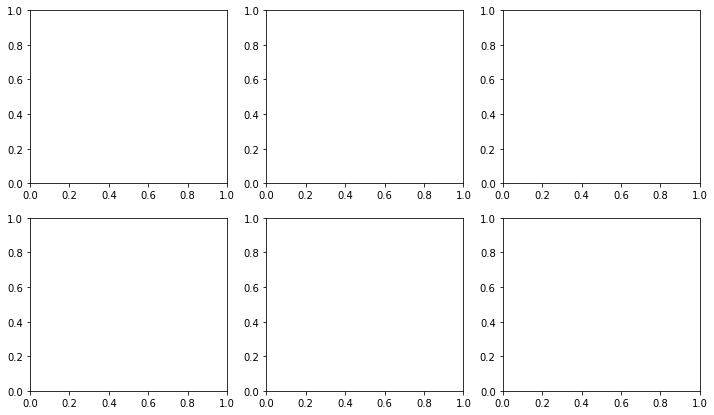

In [2]:
""" Copyright chriskeraly
    Copyright (c) 2019 Lumerical Inc. """

######## IMPORTS ########
# General purpose imports
import os
import numpy as np
import scipy as sp

# Optimization specific imports
from lumopt.utilities.load_lumerical_scripts import load_from_lsf
from lumopt.utilities.wavelengths import Wavelengths
from lumopt.geometries.polygon import FunctionDefinedPolygon
from lumopt.figures_of_merit.modematch import ModeMatch
from lumopt.optimizers.generic_optimizers import ScipyOptimizers
from lumopt.optimization import Optimization

######## DEFINE BASE SIMULATION ########
base_script = load_from_lsf(os.path.join(YSPLITTER_DIR_, 'splitter_base_TE_modematch.lsf'))

######## DEFINE SPECTRAL RANGE #########
# Global wavelength/frequency range for all the simulations
wavelengths = Wavelengths(start = 1300e-9, stop = 1800e-9, points = 21)

######## DEFINE OPTIMIZABLE GEOMETRY ########
# The class FunctionDefinedPolygon needs a parameterized Polygon (with points ordered
# in a counter-clockwise direction). Here the geometry is defined by 10 parameters defining
# the knots of a spline, and the resulting Polygon has 200 edges, making it quite smooth.
initial_points_x = np.linspace(-1.0e-6, 1.0e-6, 10)
initial_points_y = 0.25e-6 + (0.6e-6 - 0.25e-6) * np.power(np.sin( np.pi / 2.0 * (initial_points_x - initial_points_x.min()) / (initial_points_x.max() - initial_points_x.min()) ), 2)
def taper_splitter(params = initial_points_y):
    ''' Defines a taper where the paramaters are the y coordinates of the nodes of a cubic spline. '''
    points_x = np.concatenate(([initial_points_x.min() - 0.01e-6], initial_points_x, [initial_points_x.max() + 0.01e-6]))
    points_y = np.concatenate(([initial_points_y.min()], params, [initial_points_y.max()]))
    n_interpolation_points = 100
    polygon_points_x = np.linspace(min(points_x), max(points_x), n_interpolation_points)
    interpolator = sp.interpolate.interp1d(points_x, points_y, kind = 'cubic')
    polygon_points_y = interpolator(polygon_points_x)
    polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points = np.array(polygon_points_up[::-1] + polygon_points_down)
    return polygon_points

# The geometry will pass on the bounds and initial parameters to the optimizer.
bounds = [(0.2e-6, 0.8e-6)] * initial_points_y.size
# The permittivity of the material making the optimizable geometry and the permittivity of the material surrounding 
# it must be defined. Since this is a 2D simulation, the depth has no importance. The edge precision defines the
# discretization of the edges forming the optimizable polygon. It should be set such there are at least a few points 
# per mesh cell. An effective index of 2.8 is user to simulate a 2D slab of 220 nm thickness.
geometry = FunctionDefinedPolygon(func = taper_splitter, initial_params = initial_points_y, bounds = bounds, z = 0.0, depth = 220e-9, eps_out = 1.44 ** 2, eps_in = 2.8 ** 2, edge_precision = 5, dx = 0.1e-9)

######## DEFINE FIGURE OF MERIT ########
# The base simulation script defines a field monitor named 'fom' at the point where we want to modematch to the 3rd mode (fundamental TE mode).
fom = ModeMatch(monitor_name = 'fom', mode_number = 3, direction = 'Forward', target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1)

######## DEFINE OPTIMIZATION ALGORITHM ########
# This will run Scipy's implementation of the L-BFGS-B algoithm for at least 40 iterations. Since the variables are on the
# order of 1e-6, thery are scale up to be on the order of 1.
optimizer = ScipyOptimizers(max_iter = 30, method = 'L-BFGS-B', scaling_factor = 1e6, pgtol = 1e-9)

######## PUT EVERYTHING TOGETHER ########
opt = Optimization(base_script = base_script, wavelengths = wavelengths, fom = fom, geometry = geometry, optimizer = optimizer, hide_fdtd_cad = False, use_deps = True)

######## RUN THE OPTIMIZER ########
opt.run()



# Three-Dimensional Case

Copied directly from `lumopt/examples/Ysplitter/splitter_opt_3D.py`. Only changed to use `YSPLITTER_DIR_` to get the directory name.

Accurate interface detection enabled
Running scipy optimizer
bounds= [[0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]]
start= [0.25       0.26055379 0.29094222 0.3375     0.39461157 0.45538843
 0.5125     0.55905778 0.58944621 0.6       ]
Running forward solves


LumApiError: "in getdata, the d-card named opt_fields_index was not found.\n  This is likely because you are in Layout Mode and need to switch to Analysis Mode by running the simulation\n  or opening a simulation that contains data.\n  Also, try the command '?getdata;' to see the which global d-cards are available. Note: Vector arguments expect numpy arrays"

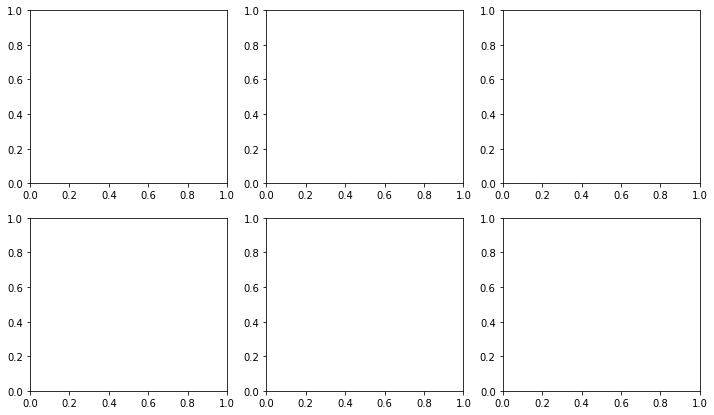

In [3]:
""" Copyright chriskeraly
    Copyright (c) 2019 Lumerical Inc. """

######## IMPORTS ########
# General purpose imports
import os
import numpy as np
import scipy as sp

# Optimization specific imports
from lumopt.utilities.load_lumerical_scripts import load_from_lsf
from lumopt.utilities.wavelengths import Wavelengths
from lumopt.utilities.materials import Material
from lumopt.geometries.polygon import FunctionDefinedPolygon
from lumopt.figures_of_merit.modematch import ModeMatch
from lumopt.optimizers.generic_optimizers import ScipyOptimizers
from lumopt.optimization import Optimization

######## DEFINE BASE SIMULATION ########
script = load_from_lsf(os.path.join(YSPLITTER_DIR_, 'splitter_base_TE_modematch_3D.lsf'))

######## DEFINE SPECTRAL RANGE #########
wavelengths = Wavelengths(start = 1300e-9, stop = 1800e-9, points = 21)

######## DEFINE DATABASE MATERIALS #####
silicon = Material(name = 'Si (Silicon) - Palik', mesh_order = 2)

######## DEFINE OPTIMIZABLE GEOMETRY ########
initial_points_x = np.linspace(-1.0e-6,1.0e-6, 10)
initial_points_y = 0.25e-6 + (0.6e-6 - 0.25e-6) * np.power(np.sin( np.pi / 2.0 * (initial_points_x - initial_points_x.min()) / (initial_points_x.max() - initial_points_x.min()) ), 2)
def taper_splitter(params = initial_points_y):
    ''' Defines a taper where the parameters are the y coordinates of the nodes of a cubic spline.'''
    points_x = np.concatenate(([initial_points_x.min() - 0.01e-6], initial_points_x, [initial_points_x.max() + 0.01e-6]))
    points_y = np.concatenate(([initial_points_y.min()], params, [initial_points_y.max()]))
    n_interpolation_points = 100
    polygon_points_x = np.linspace(min(points_x), max(points_x), n_interpolation_points)
    interpolator = sp.interpolate.interp1d(points_x, points_y, kind = 'cubic')
    polygon_points_y = interpolator(polygon_points_x)
    polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points = np.array(polygon_points_up[::-1] + polygon_points_down)
    return polygon_points
bounds = [(0.2e-6, 0.8e-6)] * initial_points_y.size
geometry = FunctionDefinedPolygon(func = taper_splitter, initial_params = initial_points_y, bounds = bounds, z = 0.0, depth = 220e-9, eps_out = 1.44 ** 2, eps_in = silicon, edge_precision = 5, dx = 0.1e-9)

######## DEFINE FIGURE OF MERIT ########
fom = ModeMatch(monitor_name = 'fom', mode_number = 1, direction = 'Forward', target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1)

######## DEFINE OPTIMIZATION ALGORITHM ########
optimizer = ScipyOptimizers(max_iter = 20, method = 'L-BFGS-B', scaling_factor = 1e6, pgtol = 1e-9)

######## PUT EVERYTHING TOGETHER ########
opt = Optimization(base_script = script, wavelengths = wavelengths, fom = fom, geometry = geometry, optimizer = optimizer, hide_fdtd_cad = False, use_deps = True)

######## RUN THE OPTIMIZER ########
opt.run()
